In [3]:
options(repos = c(CRAN = "https://cran.r-project.org"))
library(pacman)



In [4]:
p_load(patchwork,envalysis,grf,rio,reshape2,stringr,ggthemes,dplyr,haven,car,ggplot2,gridExtra,haven,tidyr,polycor,psych,GPArotation,poLCA,ggpmisc)

In [5]:
data <- import("2010_2024.csv")

In [6]:
str(data)

'data.frame':	150913 obs. of  32 variables:
 $ event_id_cnty     : chr  "COL29432" "ARG15987" "ARG15990" "ARG15995" ...
 $ event_date        : chr  "22 November 2024" "22 November 2024" "22 November 2024" "22 November 2024" ...
 $ year              : int  2024 2024 2024 2024 2024 2024 2024 2024 2024 2024 ...
 $ time_precision    : int  2 1 1 1 1 1 1 1 1 1 ...
 $ disorder_type     : chr  "Political violence" "Demonstrations" "Demonstrations" "Demonstrations" ...
 $ event_type        : chr  "Violence against civilians" "Protests" "Protests" "Protests" ...
 $ sub_event_type    : chr  "Attack" "Peaceful protest" "Peaceful protest" "Peaceful protest" ...
 $ actor1            : chr  "Unidentified Armed Group (Colombia)" "Protesters (Argentina)" "Protesters (Argentina)" "Protesters (Argentina)" ...
 $ assoc_actor_1     : chr  "" "ATE: Association of State Workers; Health Workers (Argentina); Labor Group (Argentina)" "Women (Argentina)" "Students (Argentina)" ...
 $ inter1            : chr  "P

In [7]:
data <- data%>%rename("id" ="event_id_cnty","fecha" = "event_date","año"="year","tipo"="event_type")

In [8]:
data2 <- data %>% dplyr::select(id, fecha, año, country, admin1, admin2, admin3, location, latitude, longitude, timestamp,tipo)


In [9]:

data2_filtered <- data2 %>% 
  filter(tipo == "Protests")


In [10]:
table(data2$country,data2$año)

               
                 2018  2019  2020  2021  2022  2023  2024
  Argentina      2117  1266  2937  3032  2659  2397  1508
  Bolivia         328   625   779  1000  1193  1293  1547
  Brazil        11549  6672  6365  8172  9484  6958  5095
  Chile          1380  2722  1929  1367  1402  1200  1117
  Colombia       1758  2027  2162  4469  3523  4482  3210
  Ecuador         195   422   436   522  1433   456   366
  French Guiana    46     0    15    68    33    58    22
  Guyana          102    52   117    46    74    62    82
  Paraguay        297   578   765  1310  1170   827   775
  Peru            413   743  1218  1389  2050  3361  1424
  Suriname         29    12    39    41    70    36    34
  Uruguay          52    62    61    57   117   102    44
  Venezuela      2791  3676  3292  2422  2540  3108  1677

In [11]:
data2 <- data2 %>% 
  filter(country %in% c("Peru", "Colombia", "Ecuador", "Bolivia"))


In [12]:
#install.packages("showtext")
library(showtext)

# Agrega soporte para fuentes TrueType
font_add("Arial", "C:/Windows/Fonts/arial.ttf")  # Ruta de la fuente Arial
showtext_auto()  # Habilita el uso de fuentes registradas



Loading required package: sysfonts

Loading required package: showtextdb



In [13]:
library(dplyr)
library(ggplot2)
library(Cairo)

# Paso 1: Crear el dataset con el número de protestas por año y país
data2_grouped <- data2 %>%
  group_by(año, country) %>%
  summarise(protests = n(), .groups = "drop")

# Paso 2: Calcular el promedio regional por año
data2_summary <- data2_grouped %>%
  group_by(año) %>%
  summarise(
    regional_avg = mean(protests, na.rm = TRUE),  # Promedio de protestas por año
    .groups = "drop"
  )

# Paso 3: Obtener el último punto para cada país (último año con datos)
last_points <- data2_grouped %>%
  group_by(country) %>%
  filter(año == max(año))

# Paso 4: Etiqueta para el promedio regional
regional_label <- data2_summary %>%
  filter(año == max(año)) %>%
  mutate(country = "Regional AVG")

# Crear el gráfico
my_plot <- ggplot() +
  # Líneas verticales para los años 2020 y 2023
  geom_vline(
    xintercept = c(2020, 2023),  # Años clave
    color = "red",  # Color de las líneas
    linetype = "dashed",  # Estilo de línea
    linewidth = 1          # Grosor de las líneas
  ) +
  # Líneas grises para cada país
  geom_line(
    data = data2_grouped,
    aes(x = año, y = protests, group = country),
    color = "gray70",
    linewidth = 1,
    alpha = 0.8
  ) +
  # Puntos para cada país
  geom_point(
    data = data2_grouped,
    aes(x = año, y = protests, group = country),
    color = "gray70",
    size = 2,  # Tamaño ajustado para los puntos
    alpha = 0.8
  ) +
  # Línea negra para el promedio regional
  geom_line(
    data = data2_summary,
    aes(x = año, y = regional_avg),
    color = "#333333",
    linewidth = 1.5
  ) +
  # Puntos en forma de triángulo para el promedio regional
  geom_point(
    data = data2_summary,
    aes(x = año, y = regional_avg),
    color = "#333333",
    size = 3.5,    # Tamaño ajustado para los puntos del promedio
    shape = 17     # Cambiar la forma a triángulo
  ) +
  # Etiquetas para los países al final de las líneas
  geom_text(
    data = last_points,
    aes(x = año, y = protests, label = country),
    hjust = -0.2,  # Ajusta la posición horizontal
    color = "gray40",
    size = 5       # Ajusta el tamaño del texto
  ) +
  # Etiqueta para el promedio regional
  geom_text(
    data = regional_label,
    aes(x = año, y = regional_avg, label = country),
    hjust = -0.2,  # Ajusta la posición horizontal
    color = "#333333",
    size = 5,      # Ajusta el tamaño del texto
    fontface = "bold"
  ) +
  # Etiquetas con valores del promedio regional en rectángulos blancos encima de los puntos seleccionados
  geom_label(
    data = data2_summary %>% filter(año %in% c(2020,2021, 2022, 2023)),  # Filtrar los años de interés
    aes(x = año, y = regional_avg, label = round(regional_avg, 1)),  # Redondear valores a 1 decimal
    vjust = -0.8,  # Ajustar posición vertical
    color = "black",  # Color del texto
    fill = "white",   # Fondo blanco
    size = 5,         # Tamaño del texto
    fontface = "bold",# Texto en negrita
    label.size = 0.2  # Borde del rectángulo más delgado
  ) +
  # Etiquetas y escalas
  labs(
    title = "",
    x = "Año",
    y = "Número de Protestas",
    color = "País"
  ) +
  scale_x_continuous(breaks = 2018:2024, expand = expansion(mult = c(0.05, 0.2))) +
  theme_minimal(base_size = 20) +  # Tamaño base para el texto dentro del gráfico
  theme(
    text = element_text(family = "Arial"),  # Fuente clara y legible
    plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
    axis.title.x = element_text(size = 18),  # Tamaño del texto del eje X
    axis.title.y = element_text(size = 18),  # Tamaño del texto del eje Y
    axis.text.x = element_text(size = 16),   # Tamaño de los números del eje X
    axis.text.y = element_text(size = 16),   # Tamaño de los números del eje Y
    legend.position = "top"
  )

# Guardar el gráfico con triángulos para el promedio regional y etiquetas con fondo blanco
# Guardar el gráfico con proporciones correctas
Cairo::CairoPNG(
  filename = "grafico_protestas_cairo.png",
  width = 11 * 100,  # Ajusta el ancho (10 pulgadas por 100 dpi)
  height = 8 * 100,  # Ajusta el alto (8 pulgadas por 100 dpi)
  dpi = 100          # Resolución
)

# Renderizar el gráfico en este dispositivo
print(my_plot)

# Cerrar el dispositivo gráfico
dev.off()



png 
  2

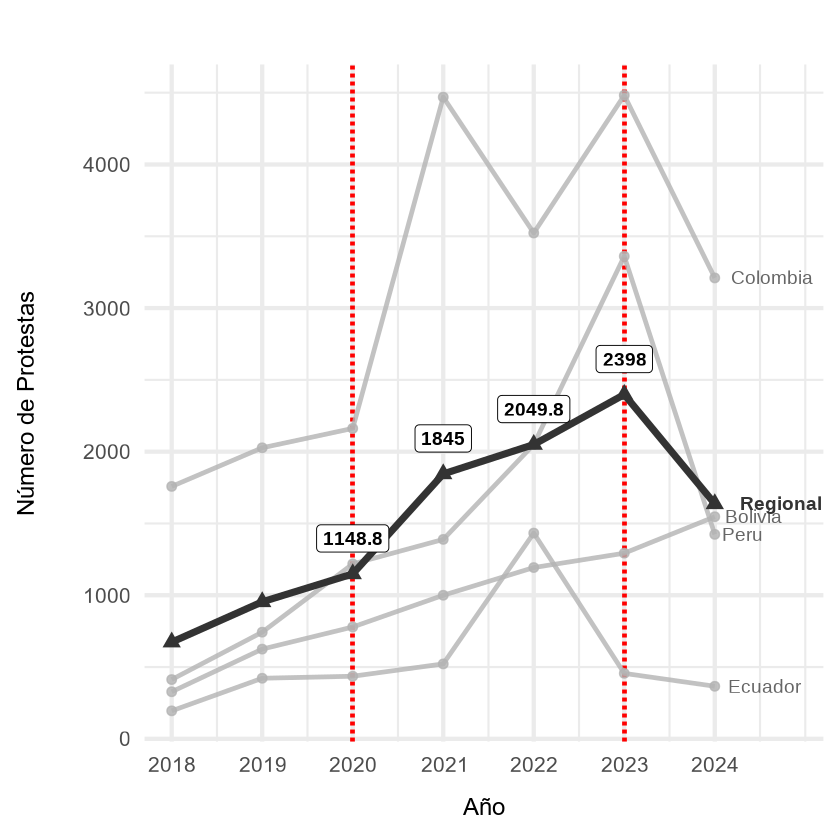

In [14]:
print(my_plot)

In [15]:
# Calcular el promedio de protestas por país y año para el gráfico facetado
data_filtered <- data2_grouped %>%
  group_by(año, country) %>%
  summarise(
    protests_mean = mean(protests, na.rm = TRUE),  # Promedio de protestas
    .groups = "drop"
  )


In [16]:
# Filtrar años del 2020 al 2023 y reordenar los países
# Convertir 'año' a factor y filtrar los años 2020-2023
data_filtered <- data_filtered %>%
  filter(año %in% 2020:2023) %>%
  mutate(año = as.factor(año)) %>%
  mutate(country = factor(country, levels = c("Ecuador", "Bolivia", "Peru", "Colombia")))

# Calcular el promedio de protestas para Ecuador
ecuador_protests_mean <- data_filtered %>%
  filter(country == "Ecuador") %>%
  summarize(mean = max(protests_mean)) %>%
  pull(mean)

# Gráfico de barras apiladas volteadas con números dentro de las barras
bar_plot_grouped_updated <- ggplot(data_filtered, aes(x = country, y = protests_mean, fill = año)) +
  # Anotación sobre Ecuador
  annotate(
    "text",
    x = "Ecuador",                # País Ecuador
    y = ecuador_protests_mean,    # Posición en el eje Y para Ecuador
    label = "País con menos protestas",  # Texto de anotación
    color = "black",                # Color del texto
    size = 6,                     # Tamaño del texto
    fontface = "bold",            # Texto en negrita
    hjust = -0.3                  # Ajuste horizontal
  ) +
  # Gráfico de barras apiladas por año
  geom_bar(stat = "identity", position = position_dodge(width = 0.9), color = "black", linewidth = 0.3) +
  # Etiquetas dentro de las barras con geom_text y fondo
  geom_text(
    aes(label = round(protests_mean, 0)),  # Redondear valores
    position = position_dodge(width = 0.9),  # Alinear etiquetas con las barras
    vjust = 0.5,  # Ajuste vertical (dentro de las barras)
    hjust = 1.1,  # Ajuste horizontal
    color = "black",  # Texto blanco para contrastar con las barras
    size = 5,         # Tamaño del texto
    fontface = "bold" # Texto en negrita
  ) +
  # Escala de grises inversa (años más recientes más oscuros)
  scale_fill_grey(start = 0.8, end = 0.4) +
  # Etiquetas y título
  labs(
    title = "",
    x = "País",
    y = "Cantidad de Protestas",
    fill = "Año"
  ) +
  # Tema profesional y minimalista
  theme_minimal(base_size = 20) +
  theme(
    text = element_text(family = "Arial"),  # Fuente profesional
    plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text.x = element_text(size = 16, color = "black", face = "bold"),  # Texto recto y negro en el eje X
    axis.text.y = element_text(size = 16),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 9),
    legend.position = "right"
  ) +
  coord_flip()  # Voltear las coordenadas

# Guardar el gráfico en alta calidad
Cairo::CairoPNG(
  filename = "grafico_barras_volteado_ecuador_destacado.png",
  width = 14 * 100,  # Ancho en píxeles
  height = 10 * 100,  # Alto en píxeles
  dpi = 300          # Resolución académica
)

# Mostrar y guardar el gráfico
print(bar_plot_grouped_updated)
dev.off()


png 
  2

# Parte 2: Gráficos de hallazgos preliminares

In [17]:
data_2020 <- import("Latinobarometro_2020_Esp_Spss_v1_0.sav")
data_2023 <- import("Latinobarometro_2023_Esp_Spss_v1_0.sav")

Invalid date string (length=9): 06 028 21
Invalid date string (length=9): 09 034 23


In [18]:
data_2023<- data_2023 %>%
  filter(IDENPA %in% c(604, 218, 68, 170))

data_2020<- data_2020 %>%
  filter(IDENPA %in% c(604, 218, 68, 170))

In [19]:
# Selección de columnas y renombrado para 2023
data_2023_filtered <- data_2023[, c("IDENPA", "NUMINVES", "P18STM.B", "P20STM","P5STGBS","P13STGBS.A","P13STGBS.B","P13ST.D","P13ST.E","P13ST.F","P13ST.H","P13ST.I","P11STGBS.A","P60ST","P16ST","P40STGBS","SEXO","REEEDUC.1","P18ST.A","S24")]
colnames(data_2023_filtered) <- c("Pais", "Año", "no-democratico", "gobierno-militar", "economia-pais","confianza_ffaa","confianza_policia","confianza_congreso","confianza_gob","confianza_pj","confianza_presi","satisfaccion","corrupcion","ideologia","interes","sexo","educacion","apoyo","socioeconomico") 
data_2023_filtered$Año <- 2023

# Selección de columnas y renombrado para 2020
data_2020_filtered <- data_2020[, c("IDENPA","NUMINVES", "P22STM.B", "P21STM","P5STGBS","P13STGBS.A","P13STGBS.B","P13ST.D","P13ST.E","P13ST.F","P13ST.H","P13ST.I","P11STGBS.A","P70ST","P18ST","P46STGBS","SEXO","REEDUC.1","P20ST.A","S30")]
colnames(data_2020_filtered) <- c("Pais", "Año", "no-democratico", "gobierno-militar", "economia-pais","confianza_ffaa","confianza_policia","confianza_congreso","confianza_gob","confianza_pj","confianza_presi","satisfaccion","corrupcion","ideologia","interes","sexo","educacion","apoyo","socioeconomico")
data_2020_filtered$Año <- 2020

# Merge de los datasets de 2023 y 2020
merged_data <- rbind(data_2023_filtered, data_2020_filtered)

# Verificar el resultado
head(merged_data)

,Pais,Año,no-democratico,gobierno-militar,economia-pais,confianza_ffaa,confianza_policia,confianza_congreso,confianza_gob,confianza_pj,confianza_presi,satisfaccion,corrupcion,ideologia,interes,sexo,educacion,apoyo,socioeconomico,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68,2023,1,2,4,3,4,3,4,3,3,3,4,3,5,3,1,5,2,2
2,68,2023,1,2,5,4,4,4,4,4,4,4,4,1,97,4,2,5,4,2
3,68,2023,1,2,3,4,3,2,4,4,3,4,3,4,NA,4,2,5,3,2
4,68,2023,NA,1,3,3,2,3,3,2,3,2,3,3,0,3,1,2,NA,3
5,68,2023,3,1,3,2,3,3,3,3,2,3,2,2,4,2,1,4,2,3
6,68,2023,2,1,3,4,4,4,4,3,3,4,3,4,4,3,1,5,2,2


In [20]:
unique(data_2020_filtered$educacion)

[1] 1 2

In [21]:
merged_data$Pais <- ifelse(merged_data$Pais == 604, "Peru",
                    ifelse(merged_data$Pais == 218, "Ecuador",
                    ifelse(merged_data$Pais == 68, "Bolivia",
                    ifelse(merged_data$Pais == 170, "Colombia", merged_data$Pais))))

In [22]:
merged_data$`gobierno-militar` <- ifelse(merged_data$`gobierno-militar` == 2, 0, 1)
merged_data$`no-democratico` <- ifelse(merged_data$`no-democratico`  %in% c(1, 2), 1, 0)
confianza_cols <- grep("^confianza_", names(merged_data), value = TRUE)

# Aplicar la recodificación a cada una de las columnas seleccionadas
merged_data[confianza_cols] <- lapply(merged_data[confianza_cols], function(x) recode(x, "1=4; 2=3; 3=2; 4=1"))

In [23]:
merged_data$`economia-pais` <-ifelse(merged_data$`economia-pais` %in% c(1, 2,3), 1, 0)

merged_data$satisfaccion <- recode(merged_data$satisfaccion, "1:2 = 1; 3:4 = 0")
merged_data$corrupcion <- recode(merged_data$corrupcion, "1:2 = 1;3:4 = 0")
merged_data$izquierda <- ifelse(merged_data$ideologia >= 0 & merged_data$ideologia <= 3, 1, 0)
merged_data$derecha <- ifelse(merged_data$ideologia >= 7 & merged_data$ideologia <= 10, 1, 0)
merged_data$ideologia <- NULL
# Reemplazar valores fuera de 1:2 y 3:4 con NA
# Asignar 1 a los valores 1 y 2, 0 a los valores 3 y 4, y NA al resto
merged_data$interes <- ifelse(merged_data$interes %in% c(1, 2), 1,
                               ifelse(merged_data$interes %in% c(3, 4), 0, NA))


merged_data$apoyo <- recode(merged_data$apoyo, "1:2 = 1; 3:4 = 0")
merged_data$socioeconomico <- recode(merged_data$socioeconomico, "1=4; 2=3; 3=2; 4=1")

merged_data$sexo <- recode(merged_data$sexo, "1 = 1; 2 = 0")
merged_data$educa <- recode(merged_data$educa, "1=1;2:3=2;4:5=3;6:7=4")

In [24]:
# Verificar los primeros valores de la columna 'interes'
head(merged_data$interes)

[1] NA NA NA NA  0  0

In [25]:
merged_data <- na.omit(merged_data)


In [26]:
colnames(merged_data)

[1] "Pais"               "Año"                "no-democratico"    
 [4] "gobierno-militar"   "economia-pais"      "confianza_ffaa"    
 [7] "confianza_policia"  "confianza_congreso" "confianza_gob"     
[10] "confianza_pj"       "confianza_presi"    "satisfaccion"      
[13] "corrupcion"         "interes"            "sexo"              
[16] "educacion"          "apoyo"              "socioeconomico"    
[19] NA                   "izquierda"          "derecha"           
[22] "educa"

In [27]:
confianza = merged_data[,c(6:11)]


In [28]:
poly_cor = polychoric(confianza)
poly_cor

Call: polychoric(x = confianza)
Polychoric correlations 
                   cnfnz_f cnfnz_pl cnfnz_c cnfnz_g cnfnz_pj cnfnz_pr
confianza_ffaa     1.00                                              
confianza_policia  0.61    1.00                                      
confianza_congreso 0.22    0.27     1.00                             
confianza_gob      0.26    0.34     0.66    1.00                     
confianza_pj       0.34    0.38     0.56    0.58    1.00             
confianza_presi    0.30    0.34     0.45    0.50    0.53     1.00    

 with tau of 
                       1    2   3
confianza_ffaa     -0.79 0.18 1.1
confianza_policia  -0.62 0.54 1.5
confianza_congreso -0.13 0.94 1.9
confianza_gob      -0.18 0.76 1.6
confianza_pj       -0.32 0.75 1.8
confianza_presi    -0.52 0.46 1.5

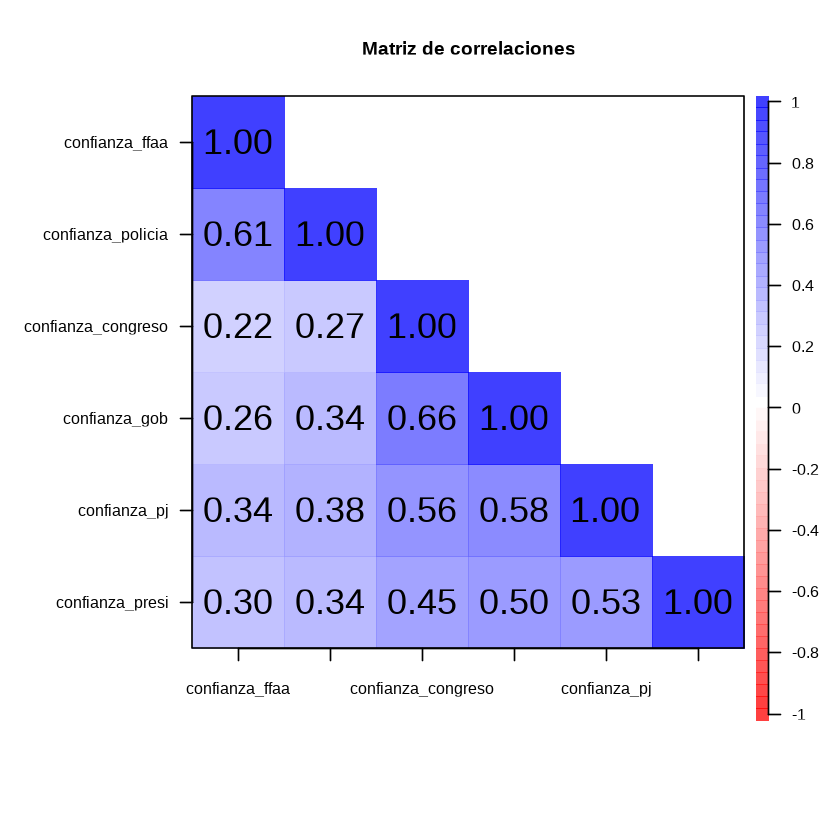

In [29]:
corMatrix=poly_cor$rho 
cor.plot(corMatrix,
          numbers=T, #Se muestren los numeros de las correlaciones
          upper=F, #Que aparezca la segunda parte
          main= "Matriz de correlaciones",#Titulo
          show.legend=T)#Mostrar leyenda

In [30]:
psych::KMO(confianza) 


Kaiser-Meyer-Olkin factor adequacy
Call: psych::KMO(r = confianza)
Overall MSA =  0.77
MSA for each item = 
    confianza_ffaa  confianza_policia confianza_congreso      confianza_gob 
              0.68               0.70               0.77               0.78 
      confianza_pj    confianza_presi 
              0.83               0.86 

In [31]:
cortest.bartlett(corMatrix,n=nrow(confianza))$p.value>0.05#Menor a 0.05 saldrá FALSE, mayor a 0.05 saldra TRUE


[1] FALSE

Warning message in fa.parallel(corMatrix, fm = "pa", fa = "fa", main = "Scree Plot"):
"It seems as if you are using a correlation matrix, but have not specified the number of cases. The number of subjects is arbitrarily set to be 100  "
Warning message in fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs, :
"The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method."
Warning message in fac(r = r, nfactors = nfactors, n.obs = n.obs, rotate = rotate, :
"An ultra-Heywood case was detected.  Examine the results carefully"
Warning message in fa.stats(r = r, f = f, phi = phi, n.obs = n.obs, np.obs = np.obs, :
"The estimated weights for the factor scores are probably incorrect.  Try a different factor score estimation method."
Warning message in fac(r = r, nfactors = nfactors, n.obs = n.obs, rotate = rotate, :
"An ultra-Heywood case was detected.  Examine the results carefully"


Parallel analysis suggests that the number of factors =  2  and the number of components =  NA 


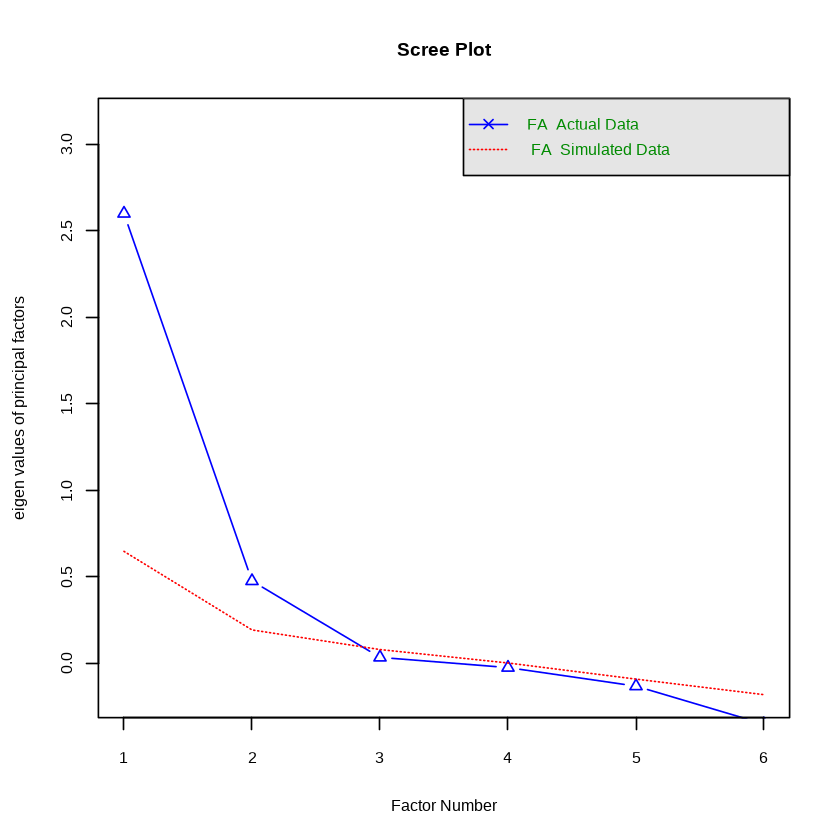

In [32]:
fa.parallel(corMatrix, fm="pa", fa="fa", main = "Scree Plot")


In [33]:
eigenf = eigen(cor(confianza, use="complete"))
eigenf$values

[1] 2.7850452 1.1496859 0.6430498 0.5210194 0.4701086 0.4310911

In [34]:
factorial <- fa(confianza,nfactors= 2 ,rotate = "varimax",fm="minres")
factorial

Factor Analysis using method =  minres
Call: fa(r = confianza, nfactors = 2, rotate = "varimax", fm = "minres")
Standardized loadings (pattern matrix) based upon correlation matrix
                    MR1  MR2   h2   u2 com
confianza_ffaa     0.15 0.71 0.52 0.48 1.1
confianza_policia  0.22 0.70 0.54 0.46 1.2
confianza_congreso 0.71 0.09 0.52 0.48 1.0
confianza_gob      0.74 0.14 0.56 0.44 1.1
confianza_pj       0.63 0.27 0.47 0.53 1.3
confianza_presi    0.53 0.26 0.35 0.65 1.4

                       MR1  MR2
SS loadings           1.80 1.16
Proportion Var        0.30 0.19
Cumulative Var        0.30 0.49
Proportion Explained  0.61 0.39
Cumulative Proportion 0.61 1.00

Mean item complexity =  1.2
Test of the hypothesis that 2 factors are sufficient.

df null model =  15  with the objective function =  1.53 with Chi Square =  2719.54
df of  the model are 4  and the objective function was  0.01 

The root mean square of the residuals (RMSR) is  0.02 
The df corrected root mean square of th

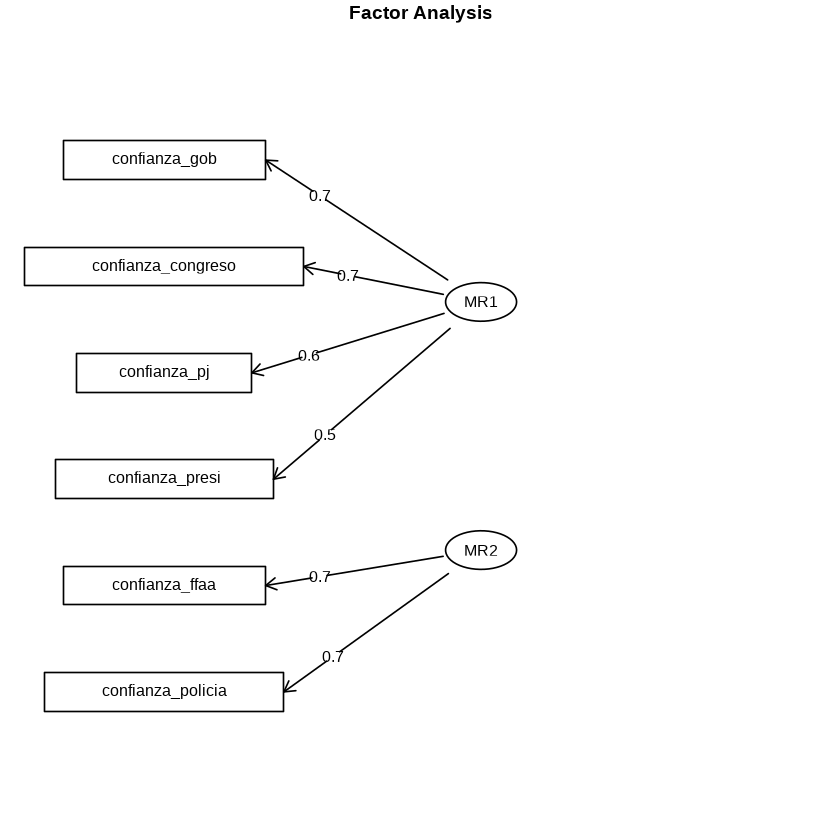

In [35]:
fa.diagram(factorial)


In [36]:
print(factorial$loadings,cutoff = 0.4)



Loadings:
                   MR1   MR2  
confianza_ffaa           0.708
confianza_policia        0.701
confianza_congreso 0.713      
confianza_gob      0.735      
confianza_pj       0.631      
confianza_presi    0.530      

                 MR1   MR2
SS loadings    1.798 1.158
Proportion Var 0.300 0.193
Cumulative Var 0.300 0.493


In [37]:
factorial_casos<-as.data.frame(factorial$scores)
head(factorial_casos)
summary(factorial_casos)

,MR1,MR2
,<dbl>,<dbl>
5,0.31537475,0.28037097
6,-0.50172392,-1.08562442
25,-0.15831172,0.04037098
37,1.22068828,0.26848696
60,0.02323103,-0.66410922
69,-0.25433065,-1.21439710


      MR1                MR2         
 Min.   :-1.38500   Min.   :-1.6665  
 1st Qu.:-0.76803   1st Qu.:-0.6025  
 Median :-0.05567   Median :-0.1171  
 Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.52347   3rd Qu.: 0.6748  
 Max.   : 3.01717   Max.   : 2.0828  

In [38]:
#Indice aditivo de confianza fuerzas del orden
merged_data$confianza_fuerzas <- rowSums(merged_data[, 6:7], na.rm = TRUE)
summary(merged_data$confianza_fuerzas)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   3.000   4.000   4.442   6.000   8.000 

In [39]:
merged_data$confianza_fuerzas <- ((merged_data$confianza_fuerzas - 2) / (8 - 2)) * 100

In [40]:
summary(merged_data$confianza_fuerzas)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   16.67   33.33   40.70   66.67  100.00 

In [41]:
merged_data$confianza_ipol <- rowSums(merged_data[,8:11])
summary(merged_data$confianza_ipol)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.000   5.000   7.000   7.588   9.000  16.000 

In [42]:
merged_data$confianza_ipol <- ((merged_data$confianza_ipol - 4) / (16 - 4)) * 100

# Desarrollo de gráficos

### Gobierno no democrático

1. **Gobierno no democrático - Economía pais**

In [43]:
data_peru <- merged_data[merged_data$Pais == "Peru",]
data_colombia <- merged_data[merged_data$Pais == "Colombia",]
data_ecuador <- merged_data[merged_data$Pais == "Ecuador",]
data_bolivia <- merged_data[merged_data$Pais == "Bolivia",]

In [44]:
#install.packages("ggtext")
library(ggtext)

In [45]:

peru <- ggplot(data_peru, aes(x = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo")), 
                      y = ..prop.., 
                      fill = factor(Año))) +
  geom_bar(position = position_dodge(width = 0.65), stat = "count", aes(group = factor(Año)), width = 0.6) +  # Barras agrupadas por año
  geom_text(aes(label = scales::percent(..prop.., accuracy = 1), 
                group = factor(Año)), 
            stat = "count", 
            position = position_dodge(width = 0.8), 
            vjust = -0.5, 
            size = 4, 
            fontface = "bold", 
            family = "Arial") +  # Agregar porcentajes sobre las barras
  facet_wrap(~factor(`economia-pais`, labels = c("Mala", "Buena")), ncol = 2) +  # Mover categorías arriba
  labs(
    title = "", # Título principal
    x = "Actitudes hacia un Gobierno No Democrático",
    y = "Porcentaje",
    fill = "Año"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +  # Eje Y en porcentaje, hasta 100%
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),  # Título centrado
    axis.text.x = element_text(family = "Arial"),  # Etiquetas del eje X
    axis.text.y = element_text(family = "Arial"),  # Etiquetas del eje Y
    axis.title.x = element_text(family = "Arial"),  # Título del eje X
    axis.title.y = element_text(family = "Arial"),  # Título del eje Y
    legend.title = element_text(size = 10, family = "Arial"),  # Título de la leyenda
    legend.text = element_text(size = 9, family = "Arial"),  # Texto de la leyenda
    legend.position = "bottom",  # Mover leyenda abajo
    strip.text = element_text(family = "Arial", face = "bold", size = 10, color = "black"),  # Texto de las etiquetas de las facetas
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),  # Fondo gris y bordes negros con ancho de línea
    panel.spacing = unit(1, "lines"),  # Espaciado entre paneles
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)  # Margen superior para dar espacio al título
  )


In [46]:

colombia <- ggplot(data_colombia, aes(x = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo")), 
                      y = ..prop.., 
                      fill = factor(Año))) +
  geom_bar(position = position_dodge(width = 0.65), stat = "count", aes(group = factor(Año)), width = 0.6) +  # Barras agrupadas por año
  geom_text(aes(label = scales::percent(..prop.., accuracy = 1), 
                group = factor(Año)), 
            stat = "count", 
            position = position_dodge(width = 0.8), 
            vjust = -0.5, 
            size = 4, 
            fontface = "bold", 
            family = "Arial") +  # Agregar porcentajes sobre las barras
  facet_wrap(~factor(`economia-pais`, labels = c("Mala", "Buena")), ncol = 2) +  # Mover categorías arriba
  labs(
    title = "", # Título principal
    x = "Actitudes hacia un Gobierno No Democrático",
    y = "Porcentaje",
    fill = "Año"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +  # Eje Y en porcentaje, hasta 100%
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),  # Título centrado
    axis.text.x = element_text(family = "Arial"),  # Etiquetas del eje X
    axis.text.y = element_text(family = "Arial"),  # Etiquetas del eje Y
    axis.title.x = element_text(family = "Arial"),  # Título del eje X
    axis.title.y = element_text(family = "Arial"),  # Título del eje Y
    legend.title = element_text(size = 10, family = "Arial"),  # Título de la leyenda
    legend.text = element_text(size = 9, family = "Arial"),  # Texto de la leyenda
    legend.position = "bottom",  # Mover leyenda abajo
    strip.text = element_text(family = "Arial", face = "bold", size = 10, color = "black"),  # Texto de las etiquetas de las facetas
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),  # Fondo gris y bordes negros con ancho de línea
    panel.spacing = unit(1, "lines"),  # Espaciado entre paneles
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)  # Margen superior para dar espacio al título
  )

In [47]:

ecuador <- ggplot(data_ecuador, aes(x = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo")), 
                      y = ..prop.., 
                      fill = factor(Año))) +
  geom_bar(position = position_dodge(width = 0.65), stat = "count", aes(group = factor(Año)), width = 0.6) +  # Barras agrupadas por año
  geom_text(aes(label = scales::percent(..prop.., accuracy = 1), 
                group = factor(Año)), 
            stat = "count", 
            position = position_dodge(width = 0.8), 
            vjust = -0.5, 
            size = 4, 
            fontface = "bold", 
            family = "Arial") +  # Agregar porcentajes sobre las barras
  facet_wrap(~factor(`economia-pais`, labels = c("Mala", "Buena")), ncol = 2) +  # Mover categorías arriba
  labs(
    title = "", # Título principal
    x = "Actitudes hacia un Gobierno No Democrático",
    y = "Porcentaje",
    fill = "Año"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +  # Eje Y en porcentaje, hasta 100%
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),  # Título centrado
    axis.text.x = element_text(family = "Arial"),  # Etiquetas del eje X
    axis.text.y = element_text(family = "Arial"),  # Etiquetas del eje Y
    axis.title.x = element_text(family = "Arial"),  # Título del eje X
    axis.title.y = element_text(family = "Arial"),  # Título del eje Y
    legend.title = element_text(size = 10, family = "Arial"),  # Título de la leyenda
    legend.text = element_text(size = 9, family = "Arial"),  # Texto de la leyenda
    legend.position = "bottom",  # Mover leyenda abajo
    strip.text = element_text(family = "Arial", face = "bold", size = 10, color = "black"),  # Texto de las etiquetas de las facetas
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),  # Fondo gris y bordes negros con ancho de línea
    panel.spacing = unit(1, "lines"),  # Espaciado entre paneles
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)  # Margen superior para dar espacio al título
  )

In [48]:

bolivia <- ggplot(data_bolivia, aes(x = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo")), 
                      y = ..prop.., 
                      fill = factor(Año))) +
  geom_bar(position = position_dodge(width = 0.65), stat = "count", aes(group = factor(Año)), width = 0.6) +  # Barras agrupadas por año
  geom_text(aes(label = scales::percent(..prop.., accuracy = 1), 
                group = factor(Año)), 
            stat = "count", 
            position = position_dodge(width = 0.8), 
            vjust = -0.5, 
            size = 4, 
            fontface = "bold", 
            family = "Arial") +  # Agregar porcentajes sobre las barras
  facet_wrap(~factor(`economia-pais`, labels = c("Mala", "Buena")), ncol = 2) +  # Mover categorías arriba
  labs(
    title = "", # Título principal
    x = "Actitudes hacia un Gobierno No Democrático",
    y = "Porcentaje",
    fill = "Año"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +  # Eje Y en porcentaje, hasta 100%
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),  # Título centrado
    axis.text.x = element_text(family = "Arial"),  # Etiquetas del eje X
    axis.text.y = element_text(family = "Arial"),  # Etiquetas del eje Y
    axis.title.x = element_text(family = "Arial"),  # Título del eje X
    axis.title.y = element_text(family = "Arial"),  # Título del eje Y
    legend.title = element_text(size = 10, family = "Arial"),  # Título de la leyenda
    legend.text = element_text(size = 9, family = "Arial"),  # Texto de la leyenda
    legend.position = "bottom",  # Mover leyenda abajo
    strip.text = element_text(family = "Arial", face = "bold", size = 10, color = "black"),  # Texto de las etiquetas de las facetas
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),  # Fondo gris y bordes negros con ancho de línea
    panel.spacing = unit(1, "lines"),  # Espaciado entre paneles
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)  # Margen superior para dar espacio al título
  )

In [49]:
# Reparar nombres vacíos o NA en cada data.frame
colnames(data_peru)[is.na(colnames(data_peru)) | colnames(data_peru) == ""] <- "temp"
colnames(data_colombia)[is.na(colnames(data_colombia)) | colnames(data_colombia) == ""] <- "temp"
colnames(data_ecuador)[is.na(colnames(data_ecuador)) | colnames(data_ecuador) == ""] <- "temp"
colnames(data_bolivia)[is.na(colnames(data_bolivia)) | colnames(data_bolivia) == ""] <- "temp"


In [50]:
library(dplyr)

# Combinar los data.frames
data_combined <- bind_rows(
  data_peru %>% mutate(País = "Perú"),
  data_colombia %>% mutate(País = "Colombia"),
  data_ecuador %>% mutate(País = "Ecuador"),
  data_bolivia %>% mutate(País = "Bolivia")
)


In [51]:
data_combined$ig

NULL

In [52]:
#para economia

In [53]:
# Crear data_with_counts_2 usando 'gobierno-militar' en lugar de 'no-democratico'
data_with_counts_2 <- data_combined %>%
  group_by(País, `gobierno-militar`, `economia-pais`, Año) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, `gobierno-militar`, `economia-pais`) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Verifica que 'data_with_counts_2' tiene los datos correctos
head(data_with_counts_2)


País,gobierno-militar,economia-pais,Año,Frecuencia,Prop
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Bolivia,0,0,2020,128,0.8476821
Bolivia,0,0,2023,23,0.1523179
Bolivia,0,1,2020,56,0.2978723
Bolivia,0,1,2023,132,0.7021277
Bolivia,1,0,2020,36,0.7500000
Bolivia,1,0,2023,12,0.2500000


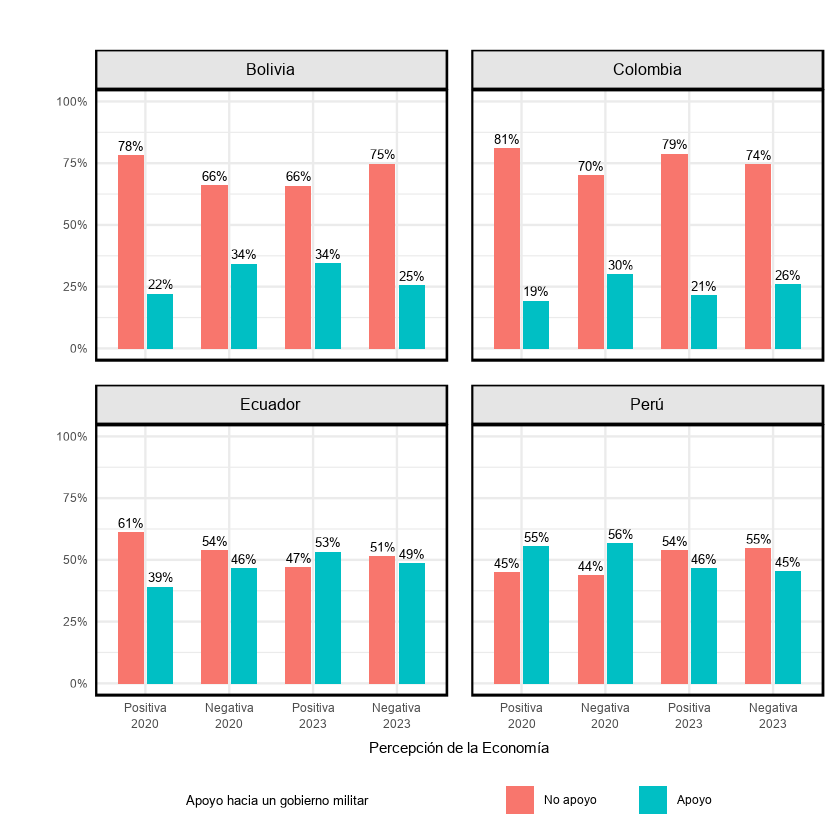

In [54]:
# Calcular proporciones por país, economía y año
data_with_counts_2 <- data_with_counts_2 %>%
  group_by(País,`economia-pais`, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

ggplot(data_with_counts_2, aes(
  x = interaction(factor(`economia-pais`, labels = c("Positiva", "Negativa")), 
                  factor(Año, levels = c("2020", "2023"))), 
  y = Prop, 
  fill = factor(`gobierno-militar`, labels = c("No apoyo", "Apoyo"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) + # Escala fija para todos los gráficos
  labs(
    x = "Percepción de la Economía",
    y = "",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) + # Eje Y en porcentaje (0% a 100%)
  scale_x_discrete(labels = function(x) gsub("\\.", "\n", x)) + # Dividir etiquetas en dos líneas (Percepción y Año)
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), # Bordes para las facetas
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )




#### Confianza fuerzas - gob_no democrático

In [55]:
colnames(data_combined)

[1] "Pais"               "Año"                "no-democratico"    
 [4] "gobierno-militar"   "economia-pais"      "confianza_ffaa"    
 [7] "confianza_policia"  "confianza_congreso" "confianza_gob"     
[10] "confianza_pj"       "confianza_presi"    "satisfaccion"      
[13] "corrupcion"         "interes"            "sexo"              
[16] "educacion"          "apoyo"              "socioeconomico"    
[19] "temp"               "izquierda"          "derecha"           
[22] "educa"              "confianza_fuerzas"  "confianza_ipol"    
[25] "País"

In [56]:
summary(data_combined$confianza_fuerzas)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   16.67   33.33   40.70   66.67  100.00 

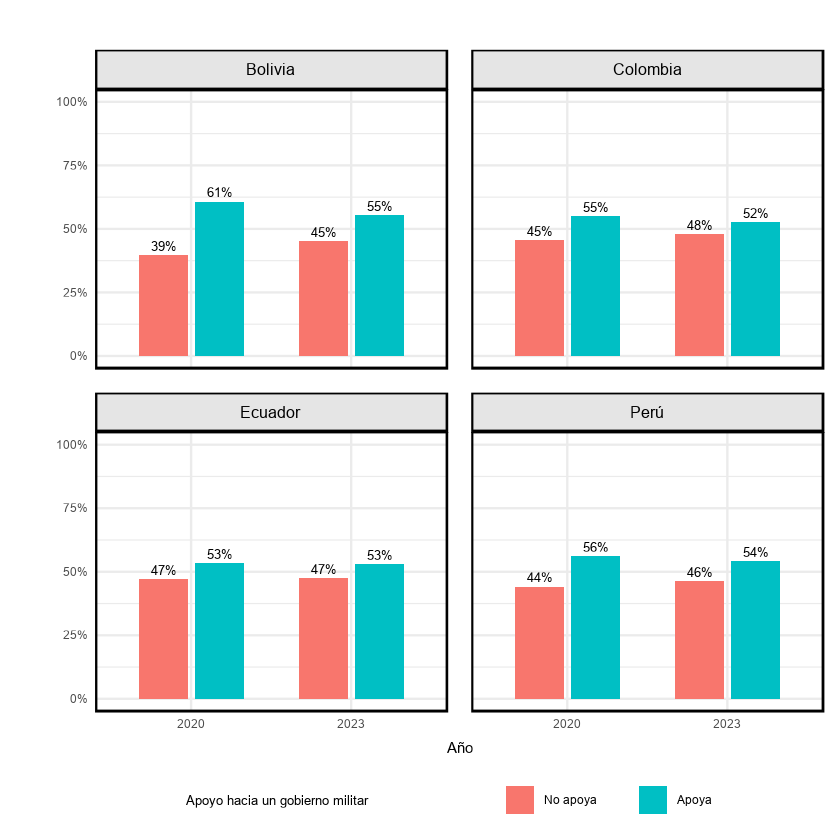

In [57]:
# Calcular proporciones para que sumen al 100% dentro de cada grupo de País, Año y Actitud
data_combined_normalized <- data_combined %>%
  group_by(País, Año, `gobierno-militar`) %>%
  summarise(Promedio_Confianza = mean(confianza_fuerzas, na.rm = TRUE), .groups = "drop") %>%
  group_by(País, Año) %>%
  mutate(Prop = Promedio_Confianza / sum(Promedio_Confianza), .groups = "drop") %>%
  ungroup()

# Crear el gráfico con proporciones normalizadas
ggplot(data_combined_normalized, aes(
  x = factor(Año),
  y = Prop,
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Año",
    y = "",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


#### confianza inst_pol - gobierno - no democrático

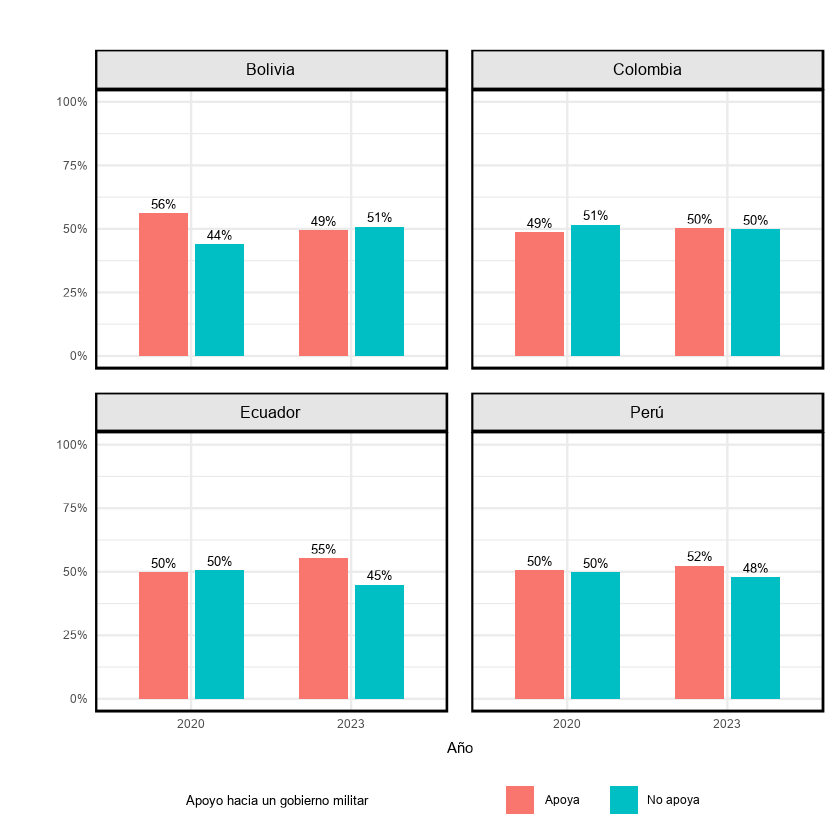

In [58]:
# Calcular proporciones para que sumen al 100% dentro de cada grupo de País, Año y Actitud
data_combined_normalized <- data_combined %>%
  group_by(País, Año, `gobierno-militar`) %>%
  summarise(Promedio_Confianza_i = mean(confianza_ipol, na.rm = TRUE), .groups = "drop") %>%
  group_by(País, Año) %>%
  mutate(Prop_i = Promedio_Confianza_i / sum(Promedio_Confianza_i), .groups = "drop") %>%
  ungroup()

# Crear el gráfico con proporciones normalizadas
ggplot(data_combined_normalized, aes(
  x = factor(Año),
  y = Prop_i,
  fill = factor(`gobierno-militar`, labels = c("Apoya", "No apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop_i, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Año",
    y = "",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


satisfaccion + no_Democratico

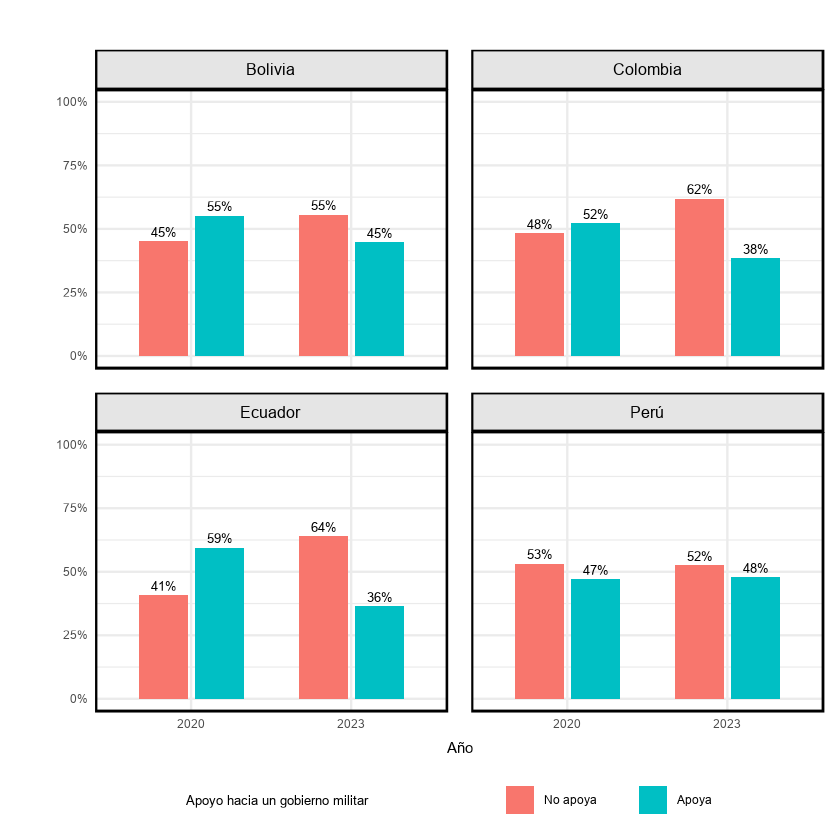

In [59]:
# Calcular proporciones para que sumen al 100% dentro de cada grupo de País, Año y Actitud
data_combined_normalized <- data_combined %>%
  group_by(País, Año, `gobierno-militar`) %>%
  summarise(Promedio_sat = mean(satisfaccion, na.rm = TRUE), .groups = "drop") %>%
  group_by(País, Año) %>%
  mutate(Prop_sat = Promedio_sat / sum(Promedio_sat), .groups = "drop") %>%
  ungroup()

# Crear el gráfico con proporciones normalizadas
ggplot(data_combined_normalized, aes(
  x = factor(Año),
  y = Prop_sat,
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop_sat, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Año",
    y = "",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8),
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8),
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


### corrupcion - nodemocratico

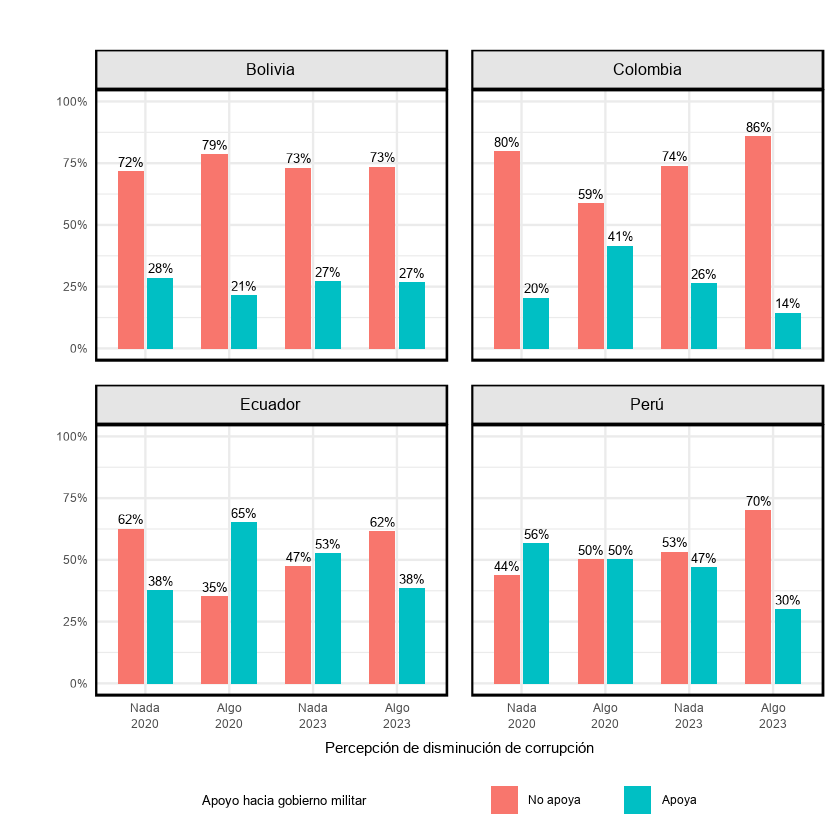

In [60]:
# Calcular proporciones por país, corrupción y año
data_with_corruption <- data_combined %>%
  group_by(País, corrupcion, Año, `gobierno-militar`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, corrupcion, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia), .groups = "drop") %>%
  ungroup()

# Crear el gráfico
ggplot(data_with_corruption, aes(
  x = interaction(factor(corrupcion, labels = c("Nada", "Algo")), 
                  factor(Año, levels = c("2020", "2023"))), 
  y = Prop, 
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Percepción de disminución de corrupción",
    y = "",
    fill = "Apoyo hacia gobierno militar"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_x_discrete(labels = function(x) gsub("\\.", "\n", x)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


derecha - no democratico

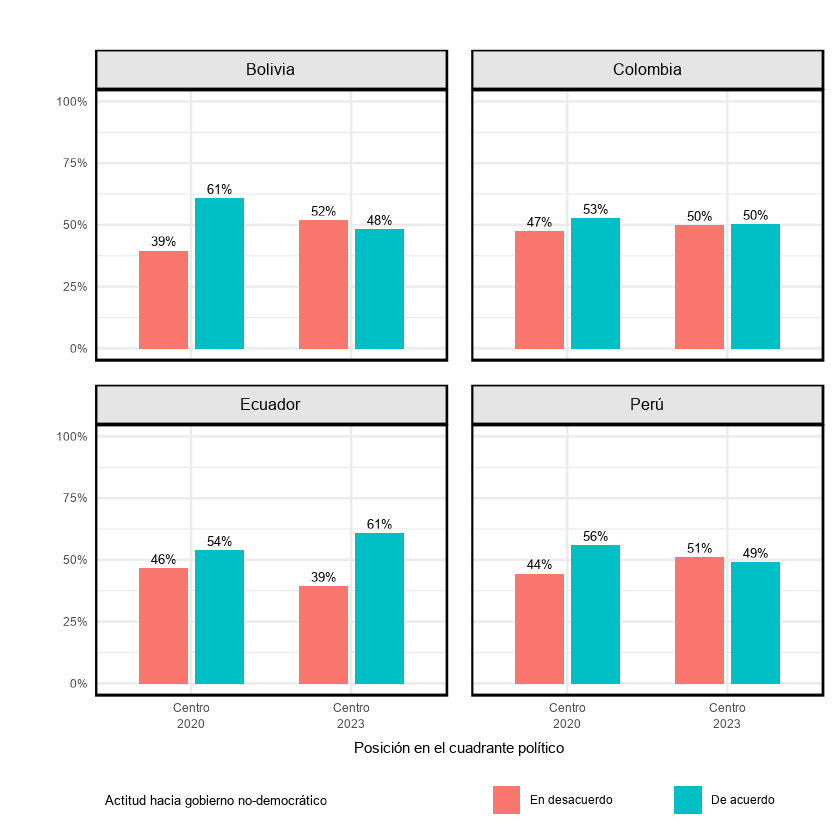

In [62]:
# Asegurarse de que los valores en 'derecha' son 0 y 1, y asignar niveles correctamente
data_with_derecha <- data_combined %>%
  group_by(País, derecha, Año, `no-democratico`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, derecha, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia), .groups = "drop") %>%
  ungroup()

# Convertir 'derecha' en factor con niveles correctos
data_with_derecha$derecha <- factor(data_with_derecha$derecha, levels = c(0, 1), labels = c("Centro", "Derecha"))

# Crear el gráfico
ggplot(data_with_derecha, aes(
  x = interaction(factor(derecha), factor(Año, levels = c("2020", "2023"))), 
  y = Prop, 
  fill = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Posición en el cuadrante político",
    y = "",
    fill = "Actitud hacia gobierno no-democrático"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_x_discrete(labels = function(x) gsub("\\.", "\n", x)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


interes - no democratico

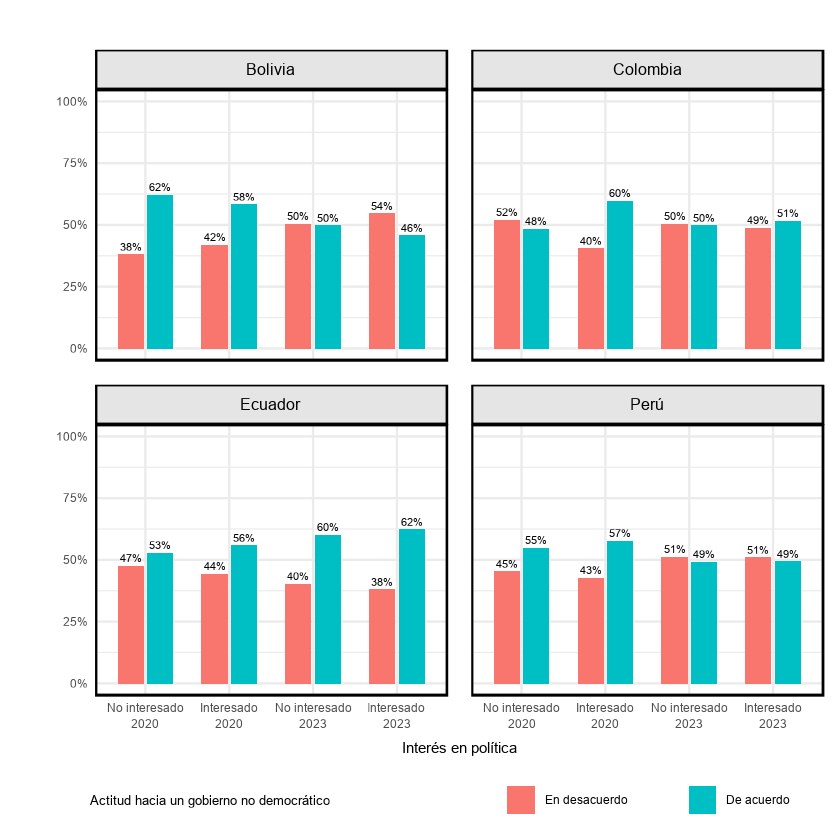

In [63]:
# Asegurarse de que los valores en 'derecha' son 0 y 1, y asignar niveles correctamente
data_with_interes <- data_combined %>%
  group_by(País, interes, Año, `no-democratico`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, interes, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia), .groups = "drop") %>%
  ungroup()

  data_with_interes_clean <- data_with_interes %>%
  filter(!is.na(interes))

# Crear el gráfico con ajustes en las etiquetas
ggplot(data_with_interes_clean, aes(
  x = interaction(factor(interes, labels = c("No interesado", "Interesado")), 
                  factor(Año, levels = c("2020", "2023"))), 
  y = Prop, 
  fill = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), 
            vjust = -0.5,  # Posición uniforme del texto
            size = 3, family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "Interés en política",
    y = "",
    fill = "Actitud hacia un gobierno no democrático"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_x_discrete(labels = function(x) gsub("\\.", "\n", x)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


apoyo - no democratico

In [64]:
# Filtrar y limpiar los datos para asegurarse de que solo haya valores 0 y 1 en 'apoyo'
data_filtered <- data_combined %>% 
  filter(!is.na(apoyo), apoyo %in% c(0, 1))  # Filtrar NAs y valores inesperados

# Agrupar y calcular las proporciones
data_with_apoyo <- data_filtered %>%
  group_by(País, apoyo, Año, `gobierno-militar`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, apoyo, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Convertir 'apoyo' en factor con niveles correctos
data_with_apoyo$apoyo <- factor(data_with_apoyo$apoyo, levels = c(0, 1), labels = c("No apoya", "Apoya"))


In [65]:
# Filtrar y limpiar los datos para asegurarse de que solo haya valores 0 y 1 en 'apoyo'
data_filtered <- data_combined %>% 
  filter(!is.na(apoyo), apoyo %in% c(0, 1))  # Filtrar NAs y valores inesperados

# Agrupar y calcular las proporciones
data_with_apoyo2 <- data_filtered %>%
  group_by(País, apoyo, Año, `no-democratico`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, apoyo, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Convertir 'apoyo' en factor con niveles correctos
data_with_apoyo2$apoyo <- factor(data_with_apoyo2$apoyo, levels = c(0, 1), labels = c("No apoya", "Apoya"))


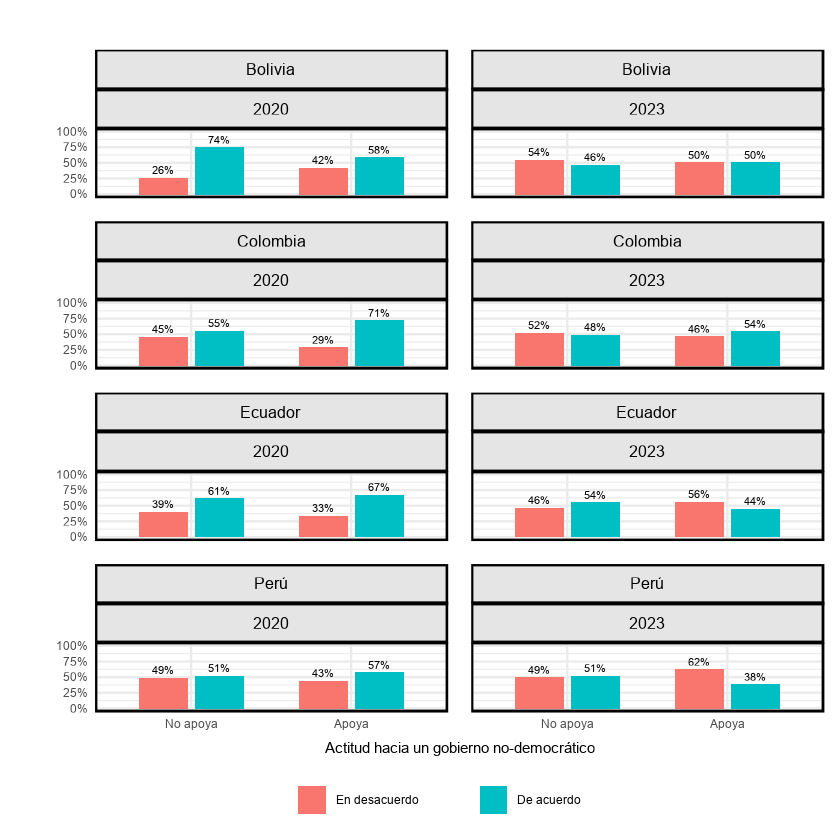

In [66]:
ggplot(data_with_apoyo2, aes(
  x = factor(apoyo, levels = c("No apoya", "Apoya")),  # Mantener solo el 'apoyo' en el eje X
  y = Prop, 
  fill = factor(`no-democratico`, labels = c("En desacuerdo", "De acuerdo"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), 
            vjust = -0.5, 
            size = 3, family = "Arial") +
  facet_wrap(~ País + Año, scales = "fixed", ncol = 2) +  # Facet by País and Año
  labs(
    y = "",
    fill = "",
    x = "Actitud hacia un gobierno no-democrático"
  ) +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.x = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.y = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  ) +
  guides(fill = guide_legend(title = NULL))  # Evitar leyenda redundante


sexo - no democratico

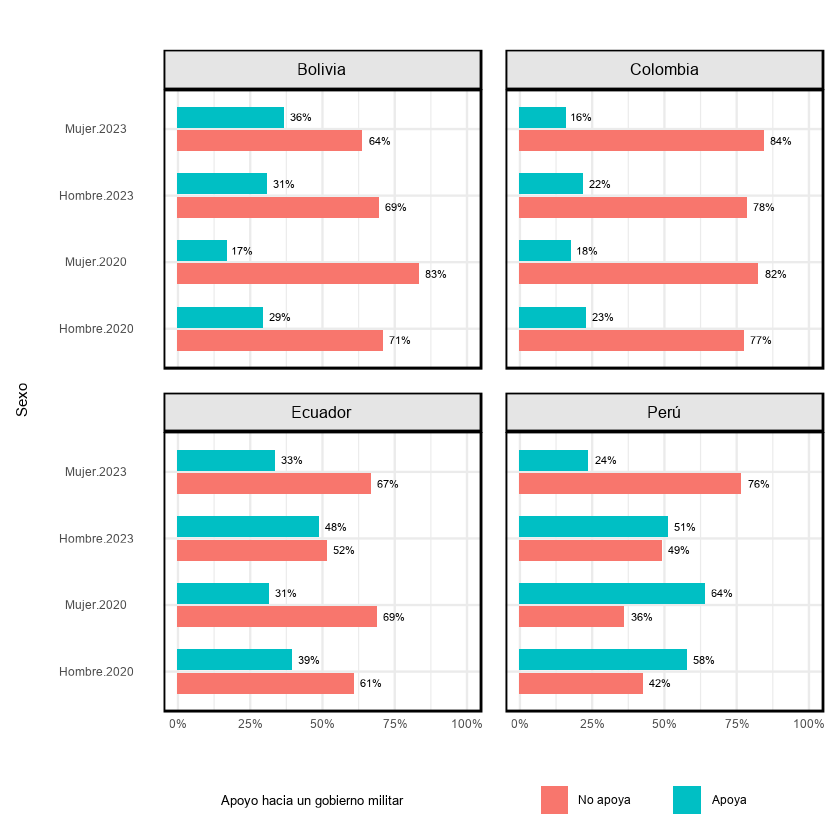

In [74]:
# Verificar y limpiar niveles inesperados en la columna 'sexo'
data_filtered <- data_combined %>%
  filter(!is.na(sexo), sexo %in% c(0, 1))  # Filtrar NAs y valores inesperados

# Agrupar y calcular proporciones
data_with_sexo <- data_filtered %>%
  group_by(País, sexo, Año, `gobierno-militar`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(País, sexo, Año) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Convertir 'sexo' en factor con niveles correctos
data_with_sexo$sexo <- factor(data_with_sexo$sexo, levels = c(0, 1), labels = c("Hombre", "Mujer"))

# Crear el gráfico con barras horizontales
ggplot(data_with_sexo, aes(
  y = interaction(factor(sexo), factor(Año, levels = c("2020", "2023"))), 
  x = Prop, 
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.7), 
            hjust = -0.3,  # Ajuste horizontal para el texto
            size = 3, 
            family = "Arial") +
  facet_wrap(~ País, scales = "fixed", ncol = 2) +
  labs(
    x = "",
    y = "Sexo",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_x_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +
  theme_minimal() +
  theme(
    plot.title = element_text(family = "Arial", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.y = element_text(family = "Arial", angle = 0, hjust = 0.5), 
    axis.text.x = element_text(family = "Arial"),
    axis.title.x = element_text(family = "Arial"), 
    axis.title.y = element_text(family = "Arial"),
    legend.title = element_text(size = 10, family = "Arial"), 
    legend.text = element_text(size = 9, family = "Arial"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "Arial", face = "bold", size = 12, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )


ingresos - no democrático

In [68]:
d2020 <- data_combined %>%
  filter(Año == "2020")

In [69]:
colnames(d2020)

[1] "Pais"               "Año"                "no-democratico"    
 [4] "gobierno-militar"   "economia-pais"      "confianza_ffaa"    
 [7] "confianza_policia"  "confianza_congreso" "confianza_gob"     
[10] "confianza_pj"       "confianza_presi"    "satisfaccion"      
[13] "corrupcion"         "interes"            "sexo"              
[16] "educacion"          "apoyo"              "socioeconomico"    
[19] "temp"               "izquierda"          "derecha"           
[22] "educa"              "confianza_fuerzas"  "confianza_ipol"    
[25] "País"

In [70]:
d2023 <- data_combined %>%
  filter(Año == "2023")

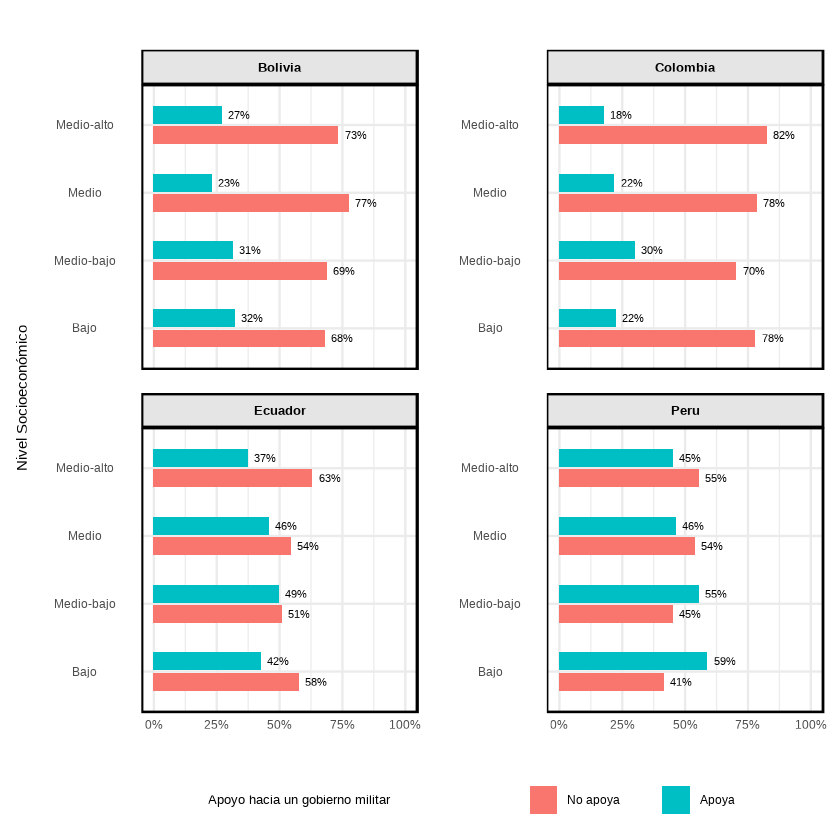

In [76]:

d2020 <- data_combined %>%
  mutate(socioeconomico = factor(socioeconomico, levels = c(1, 2, 3, 4, 5), 
                                 labels = c("Bajo", "Medio-bajo", "Medio", "Medio-alto", "Alto"))) %>%
  drop_na(Pais) %>%  # Eliminar filas con NA en la columna Pais
  group_by(Pais, socioeconomico, `gobierno-militar`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(Pais, socioeconomico) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Crear el gráfico para 2020
p_2020 <- ggplot(d2020, aes(
  y = socioeconomico, 
  x = Prop, 
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.6), width = 0.5) + 
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.6), 
            hjust = -0.3,  
            size = 3, 
            family = "sans") +  
  facet_wrap(~ Pais, scales = "free_y", ncol = 2) +
  labs(
    x = "",
    y = "Nivel Socioeconómico",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_x_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +  
  theme_minimal() +
  theme(
    plot.title = element_text(family = "sans", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.y = element_text(family = "sans", angle = 0, hjust = 0.5), 
    axis.text.x = element_text(family = "sans", size = 9),
    axis.title.x = element_text(family = "sans"), 
    axis.title.y = element_text(family = "sans"),
    legend.title = element_text(size = 10, family = "sans"), 
    legend.text = element_text(size = 9, family = "sans"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "sans", face = "bold", size = 10, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )

# Guardar el gráfico como archivo PNG
print(p_2020)

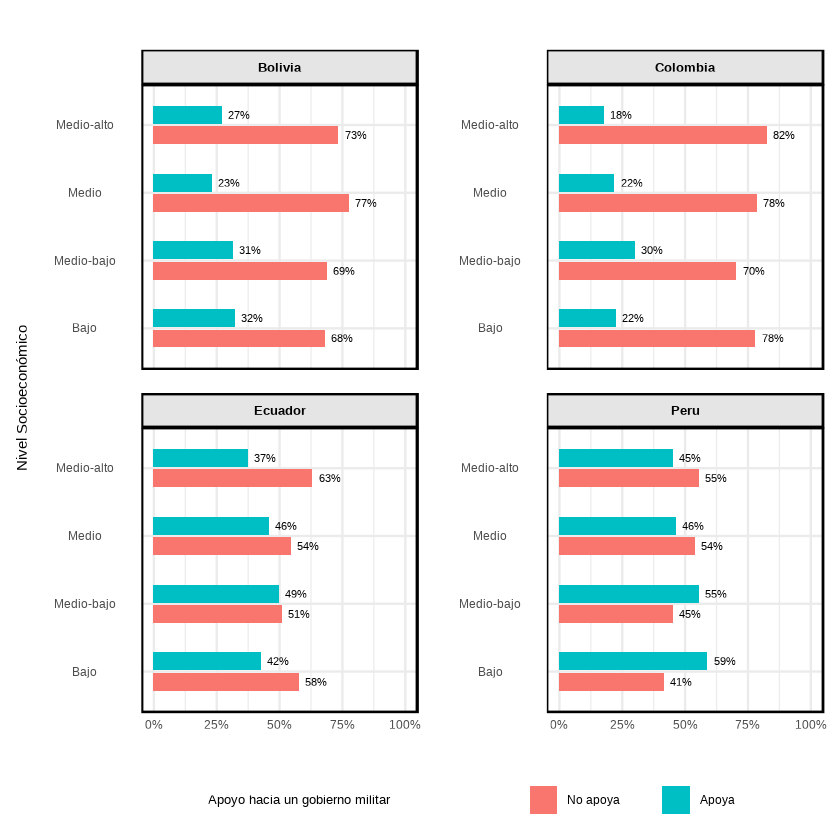

In [77]:

d2023 <- data_combined %>%
  mutate(socioeconomico = factor(socioeconomico, levels = c(1, 2, 3, 4, 5), 
                                 labels = c("Bajo", "Medio-bajo", "Medio", "Medio-alto", "Alto"))) %>%
  drop_na(Pais) %>%  # Eliminar filas con NA en la columna Pais
  group_by(Pais, socioeconomico, `gobierno-militar`) %>%
  summarise(Frecuencia = n(), .groups = "drop") %>%
  group_by(Pais, socioeconomico) %>%
  mutate(Prop = Frecuencia / sum(Frecuencia)) %>%
  ungroup()

# Crear el gráfico para 2020
p_2023 <- ggplot(d2023, aes(
  y = socioeconomico, 
  x = Prop, 
  fill = factor(`gobierno-militar`, labels = c("No apoya", "Apoya"))
)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.6), width = 0.5) + 
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
            position = position_dodge(width = 0.6), 
            hjust = -0.3,  
            size = 3, 
            family = "sans") +  
  facet_wrap(~ Pais, scales = "free_y", ncol = 2) +
  labs(
    x = "",
    y = "Nivel Socioeconómico",
    fill = "Apoyo hacia un gobierno militar"
  ) +
  scale_x_continuous(labels = scales::percent, limits = c(0, 1)) +
  scale_fill_manual(values = c("#F8766D", "#00BFC4")) +  
  theme_minimal() +
  theme(
    plot.title = element_text(family = "sans", face = "bold", size = 14, hjust = 0.5, margin = margin(b = 15)),
    axis.text.y = element_text(family = "sans", angle = 0, hjust = 0.5), 
    axis.text.x = element_text(family = "sans", size = 9),
    axis.title.x = element_text(family = "sans"), 
    axis.title.y = element_text(family = "sans"),
    legend.title = element_text(size = 10, family = "sans"), 
    legend.text = element_text(size = 9, family = "sans"), 
    legend.position = "bottom", 
    strip.text = element_text(family = "sans", face = "bold", size = 10, color = "black"), 
    strip.background = element_rect(fill = "gray90", color = "black", linewidth = 0.8), 
    panel.spacing = unit(1, "lines"),
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.8), 
    plot.margin = margin(t = 30, b = 10, l = 10, r = 10)
  )

# Guardar el gráfico como archivo PNG
print(p_2023)